In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from shapely.geometry import Point, Polygon
from collections import Counter
import geopandas
from geopy.geocoders import Nominatim
import warnings
import json
import requests
import time
import warnings
warnings.filterwarnings('ignore')

/home/frabatx/.local/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [10]:
df = pd.read_csv('data/complete.csv')
# Controllo come vengono indicizzate le variabili
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      28681 non-null  object 
 1   day            28681 non-null  int64  
 2   month          28681 non-null  int64  
 3   year           28681 non-null  int64  
 4   list_keywords  28681 non-null  object 
 5   keywords       28681 non-null  object 
 6   title          28665 non-null  object 
 7   subtitle       27094 non-null  object 
 8   text           28681 non-null  object 
 9   address        22536 non-null  object 
 10  location       21186 non-null  object 
 11  geometry       28681 non-null  object 
 12  latitude       28468 non-null  float64
 13  longitude      28468 non-null  float64
 14  cod_quart      8892 non-null   float64
 15  nome_quart     8892 non-null   object 
 16  pro_com        16385 non-null  float64
 17  comune         16385 non-null  object 
dtypes: flo

# Analisi argomentativa
Quali sono le keywords piú frequenti?
1) Keywords totali piú frequenti

2) Frequenza annuale di quelle frequenti

3) Prendere in esempio le keywords di riferimento sulla mappa dei fatti di trento, guardare se hanno pattern

In [11]:
df["list_keywords"] = df["list_keywords"].apply(lambda x: re.findall('\'([^\']*)\'', str(x))) # Transform string into list
df["keywords"] = df["keywords"].apply(lambda x: re.findall('\'([^\']*)\'', str(x))) # Transform string into list

In [26]:
def uniqueKeyword(listaInDataframe):
    #df_temp = df[df['year']=='2019']
    temp_l = list(listaInDataframe)
    temp_l = [j for i in temp_l for j in i]
    cnt = Counter(temp_l)

    key_value_count = cnt.most_common()
    key_value_count.sort(key= lambda x: x[1], reverse=True)
    total_keywords = [(x,y) for x,y in key_value_count]
    #print(len(total_keywords))
    return total_keywords

totalListKey = uniqueKeyword(df["list_keywords"])
totalKey = uniqueKeyword(df["keywords"])

list(zip(totalListKey, totalKey))[:20]

[(('Incidenti', 2866), ('Argomenti:', 2446)),
 (('Argomenti', 2446), ('incidenti', 1339)),
 (('Elezioni', 1003), ('strade', 873)),
 (('Montagna', 986), ('coronavirus', 817)),
 (('Coronavirus', 932), ('morti', 766)),
 (('Lavoro', 899), ('furti', 748)),
 (('Strade', 893), ('viabilità', 737)),
 (('Morti', 865), ('lavoro', 694)),
 (('Del', 798), ('scuola', 676)),
 (('Furti', 780), ('carabinieri', 654)),
 (('Viabilità', 741), ('ambiente', 604)),
 (('Scuola', 732), ('meteo', 572)),
 (('Trento', 730), ('droga', 567)),
 (('Carabinieri', 656), ('università', 540)),
 (('Trasporti', 635), ('trasporti', 520)),
 (('Ambiente', 615), ('montagna', 517)),
 (('Basket', 613), ('notizie curiose', 506)),
 (('Meteo', 593), ('sanità', 497)),
 (('Droga', 570), ('incendi', 486)),
 (('Università', 561), ('animali', 462))]

In [85]:
# Somma totale di tutte le keyword uniche 
len(totalKey)

4855

In [29]:
# Studio la variazione delle keywords per ogni anno. Quali sono i trend topic annuali?
years = df.year.unique()

for year in years:
    df_year = df[df['year']==year]
    print(year)
    print(list(uniqueKeyword(df_year['keywords']))[:21])

2020
[('coronavirus', 817), ('Argomenti:', 209), ('trasporti', 176), ('morti', 134), ('strade', 118), ('viabilità', 97), ('incidenti', 87), ('contagi', 80), ('orsi', 79), ('covid', 70), ('Maurizio Fugatti', 70), ('morti coronavirus', 67), ('scuola', 66), ('animali', 63), ('soccorso alpino', 63), ('mobilità', 61), ('tamponi', 58), ('elezioni comunali trento 2020', 58), ('trento', 57), ('vigili del fuoco', 53), ('dpcm', 52)]
2019
[('strade', 249), ('Argomenti:', 195), ('incidenti', 164), ('morti', 143), ('viabilità', 139), ('trasporti', 133), ('montagna', 115), ('animali', 102), ('droga', 94), ('meteo', 90), ('notizie curiose', 80), ('neve', 78), ('incendi', 74), ('mobilità', 67), ('trasporto', 66), ('vigili del fuoco', 61), ('ambiente', 60), ('furti', 59), ('traffico', 59), ('soccorso alpino', 59), ('weekend', 53)]
2018
[('Argomenti:', 240), ('incidenti', 173), ('strade', 162), ('viabilità', 125), ('montagna', 118), ('morti', 116), ('elezioni provinciali 2018', 115), ('meteo', 109), ('d

# Analisi articoli
Frequenza degli articoli annuali, quanti articoli escono all'anno? qual è la crescita? 

Quali sono i mesi piú caldi dal punto di vista dell'informazione?


In [39]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [66]:
# Documentazione groupby per le frequenze delle date
year_frequency = df.groupby(pd.Grouper(key='timestamp', freq='1Y')).size().reset_index(name='counts')
month_frequency = df.groupby(pd.Grouper(key='timestamp', freq='1M')).size().reset_index(name='counts')

In [86]:
year_frequency

,timestamp,counts
0,2011-12-31,357
1,2012-12-31,3530
2,2013-12-31,3479
3,2014-12-31,3028
4,2015-12-31,3416
5,2016-12-31,2937
6,2017-12-31,2823
7,2018-12-31,3151
8,2019-12-31,2975
9,2020-12-31,2985


In [87]:
month_frequency

,timestamp,counts
0,2011-11-30,149
1,2011-12-31,208
2,2012-01-31,191
3,2012-02-29,228
4,2012-03-31,297
...,...,...
104,2020-07-31,263
105,2020-08-31,233
106,2020-09-30,345
107,2020-10-31,381


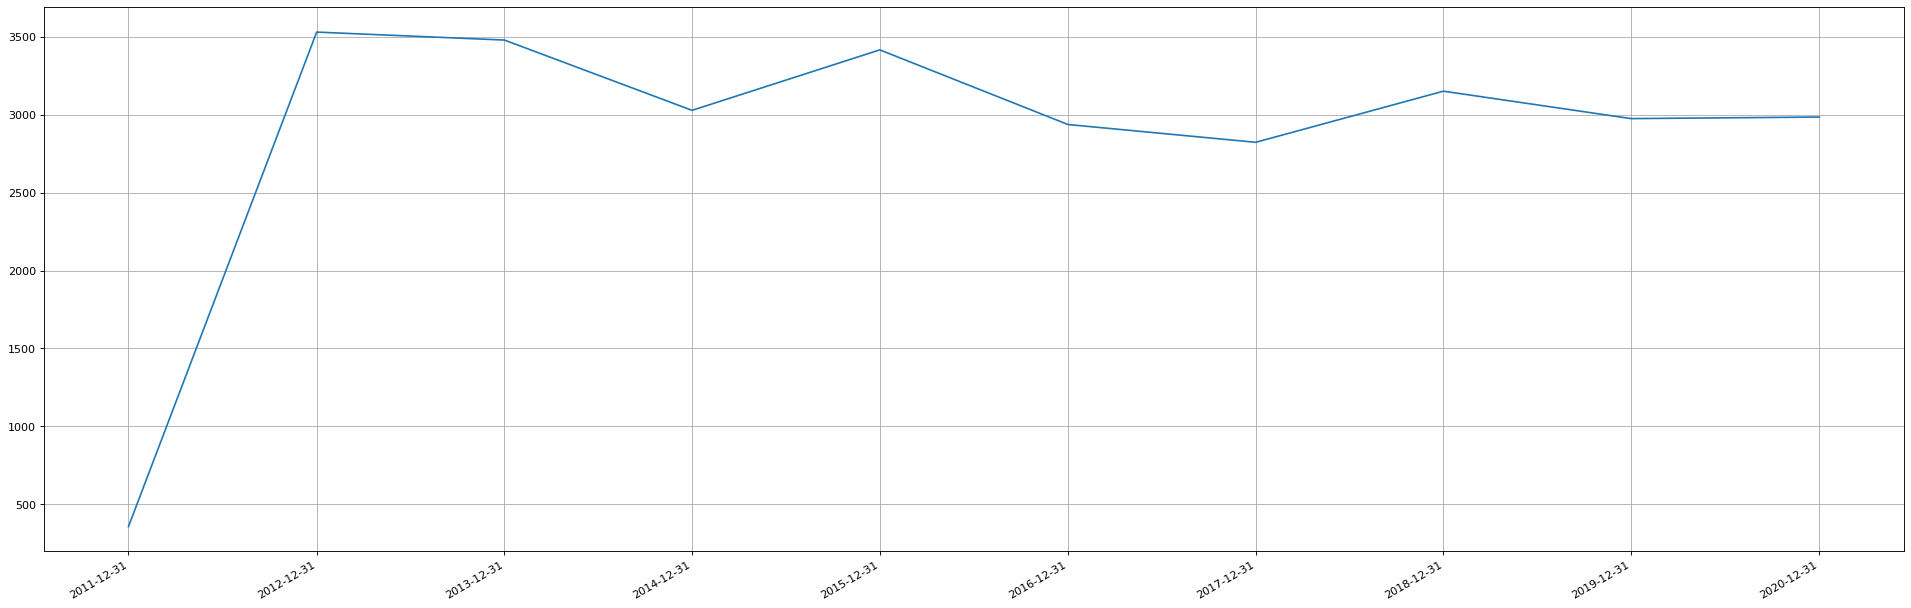

In [83]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(30,10), dpi=80, facecolor='w', edgecolor='k')

y = year_frequency['timestamp'].to_list()
c = year_frequency['counts'].to_list()
plt.plot(y,c)
plt.xticks(y)
plt.gcf().autofmt_xdate()
plt.grid(True)

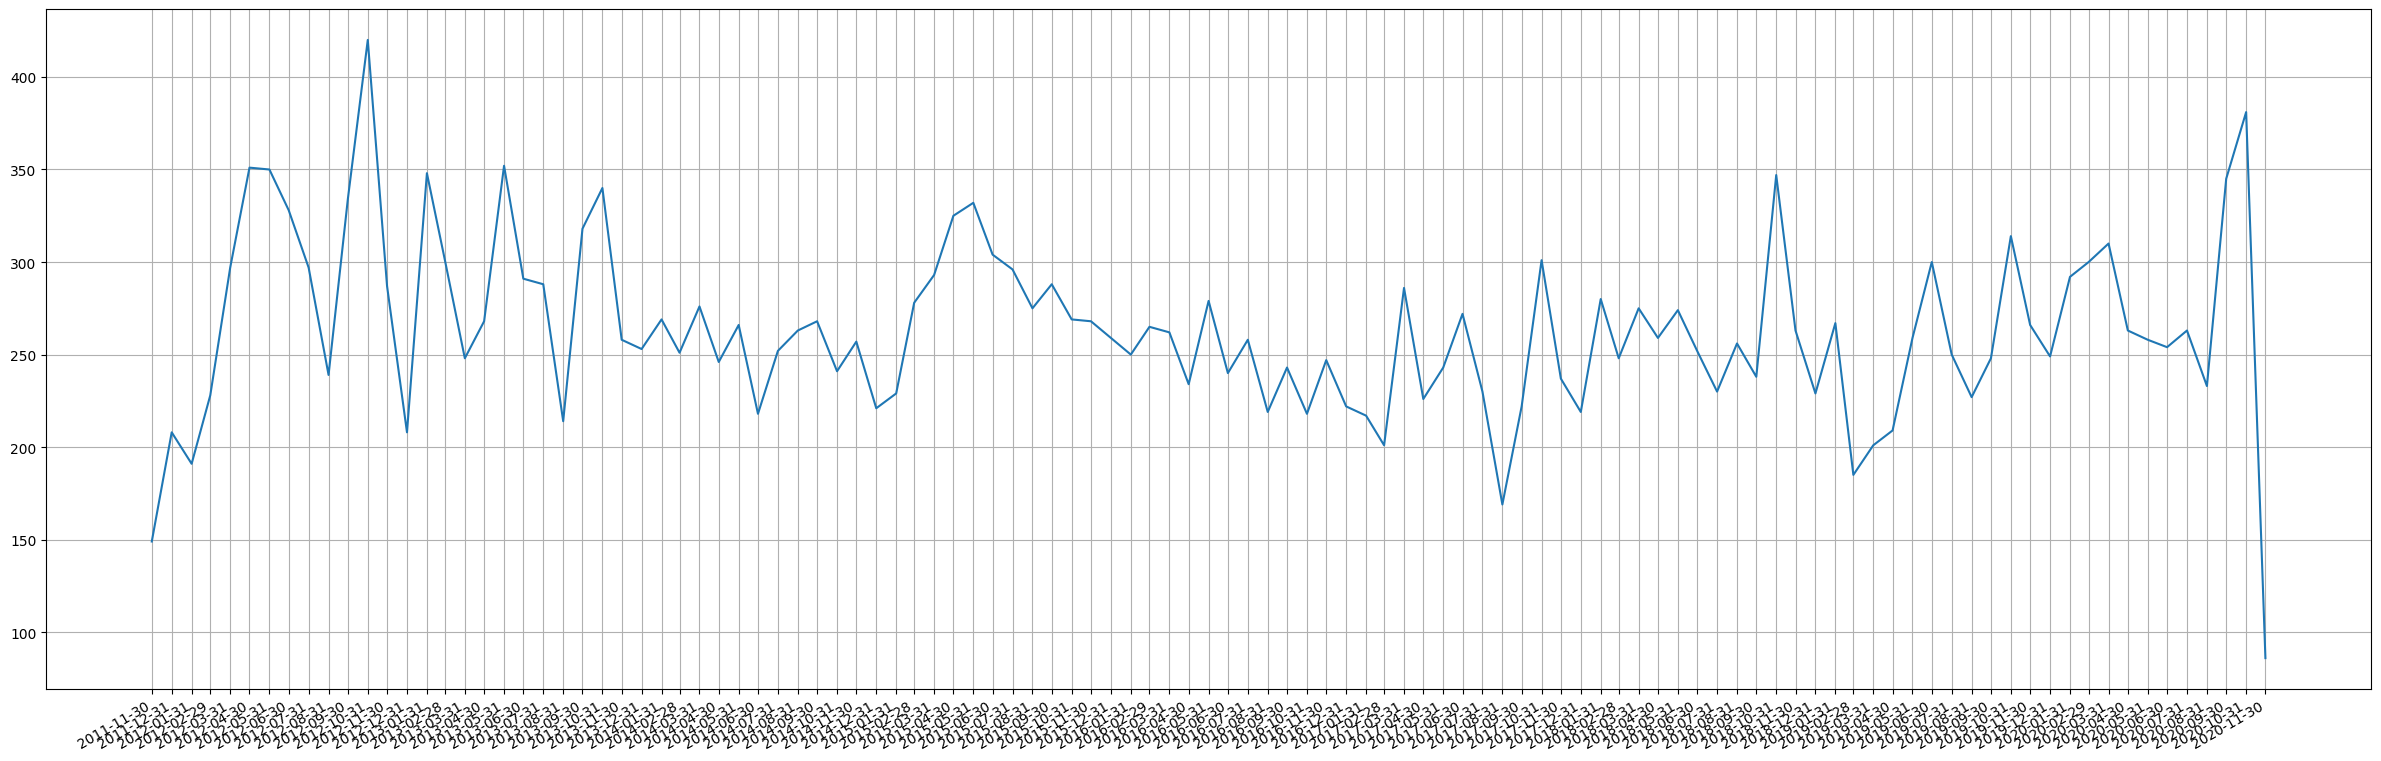

In [82]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(30,10), dpi=100, facecolor='w', edgecolor='k')

y = month_frequency['timestamp'].to_list()
c = month_frequency['counts'].to_list()
ax = plt.plot(y,c)
plt.xticks(y)
plt.gcf().autofmt_xdate()
plt.grid(True)

In [73]:
month_frequency.groupby(pd.Grouper(key='timestamp')).max()

,counts
timestamp,
2011-11-30,149
2011-12-31,208
2012-01-31,191
2012-02-29,228
2012-03-31,297
...,...
2020-07-31,263
2020-08-31,233
2020-09-30,345


In [71]:
month_frequency

,timestamp,counts
0,2011-11-30,149
1,2011-12-31,208
2,2012-01-31,191
3,2012-02-29,228
4,2012-03-31,297
...,...,...
104,2020-07-31,263
105,2020-08-31,233
106,2020-09-30,345
107,2020-10-31,381
